In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import anndata
import scanpy as sc
import sctk as sk
# import scanpy_scripts as ss

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = sk.expression_colormap()

/home/ubuntu/miniconda/envs/scanpy-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
ss.lib.set_figsize((4, 4))

In [10]:
ad0 = sc.read('../20200626_make_figure_for_Muzz/fetal_skin_bbknn.annotated.20200626.h5ad', backed='r')

Only considering the two last: ['.20200626', '.h5ad'].
Only considering the two last: ['.20200626', '.h5ad'].


In [4]:
ad0

AnnData object with n_obs × n_vars = 187293 × 28885 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'annot', 'lr_annot', 'leiden_r0_3_annot', 'leiden_r0_1_annot', 'hierarchy1', 'leiden_r1_5_annot', 'celltype', 'annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [10]:
ad0.obs.annotation.value_counts().sort_index().index

CategoricalIndex(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell',
                  'Basal KC', 'CD4 T cell', 'CD8 T cell',
                  'Capillary (venular tip)', 'Capillary/postcapillary venule',
                  'DC1', 'DC2', 'Early KC (stem cell)', 'Early LE',
                  'Early endothelial cell', 'Early erythroid',
                  'Early erythroid (embryonic)', 'Early fibroblast FRZB+',
                  'Early fibroblast HOXC5+', 'Early myocytes',
                  'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
                  'Erythroid (fetal)', 'Fibroblast POSTN+', 'Fibroblasts 1',
                  'Fibroblasts 2', 'Fibroblasts 3', 'HSC', 'Hair follicle',
                  'ILC2', 'ILC3', 'Inflammatory DC', 'LC', 'LE', 'LTi',
                  'Lymphoid progenitor', 'MEMP - Early erythroid',
                  'MEMP - Megak', 'MSC', 'Mac-mono', 'Macrophage1',
                  'Macrophage2', 'Mast cell (earliest)', 'Mast cell (medium)',
 

In [7]:
obs_df = pd.read_csv('../20200713_cellphonedb/fetal_skin.annotated.metadata.20200720.csv', index_col=0)

In [59]:
obs_df.shape

(187293, 18)

In [25]:
obs_df.columns

Index(['L1_celltypes', 'annot', 'chemistry', 'donor', 'gender', 'pcw',
       'sample', 'sanger_id', 'sorting', 'sample_sorting'],
      dtype='object')

In [8]:
obs_df.annot = obs_df.annot.str.replace('?', '')

In [11]:
obs_df = ad0.obs[['scrublet_score', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'annotation']].merge(
    obs_df, how='left', left_index=True, right_index=True)

In [12]:
obs_df.loc[obs_df.annotation != obs_df.annot, ['annotation', 'annot']].groupby(['annotation', 'annot']).size()

annotation                             annot                
Basal KC                               Basal                      547
                                       Basal POSTN+                 1
                                       Inner root sheath            1
                                       Outer root sheath            7
Early KC (stem cell)                   Basal                        8
                                       Basal POSTN+                45
                                       Immature basal              61
Early myocytes                         Myocytes                   584
                                       SM/PC                        1
Fibroblast POSTN+                      Fibroblast WNT2+         29109
Fibroblasts 1                          Pre-dermal condensate    22724
Fibroblasts 2                          Dermal condensate         5013
Fibroblasts 3                          Fibroblasts unknown       3788
Hair follicle                

In [102]:
obs_df['annot1'] = obs_df['annotation'].astype(str).copy()

obs_df.loc[obs_df.annot == 'Neuronal cells', 'annot1'] = 'Neuronal cells'
obs_df.loc[obs_df.annotation == 'Fibroblast POSTN+', 'annot1'] = 'Fibroblast WNT2+'
obs_df.loc[obs_df.annotation == 'Fibroblasts 1', 'annot1'] = 'Pre-dermal condensate'
obs_df.loc[obs_df.annotation == 'Fibroblasts 2', 'annot1'] = 'Dermal condensate'
obs_df.loc[obs_df.annotation == 'MSC', 'annot1'] = 'Dermal papillia'
obs_df.loc[obs_df.annotation == 'Fibroblasts 3', 'annot1'] = 'Fibroblasts unknown'
obs_df.loc[obs_df.annotation.isin(['Schwann cellls PID1+', 'Schwann/Schwann precusors', 'Myelinating Schwann cells']), 'annot1'] = 'Schwann cells'

In [86]:
obs_df['annot2'] = obs_df['annotation'].astype(str).copy()
obs_df.loc[obs_df.annotation == 'Fibroblast POSTN+', 'annot2'] = 'Fibroblast WNT2+'
obs_df.loc[obs_df.annotation == 'Fibroblasts 1', 'annot2'] = 'Pre-dermal condensate'
obs_df.loc[obs_df.annotation == 'Fibroblasts 2', 'annot2'] = 'Dermal condensate'
obs_df.loc[obs_df.annotation == 'Fibroblasts 3', 'annot2'] = 'Fibroblasts unknown'
k_kc = obs_df.annotation.isin(['Basal KC', 'Early KC (stem cell)', 'Periderm', 'Suprabasal', 'Hair follicle'])
obs_df.loc[k_kc, 'annot2'] = obs_df.annot[k_kc].values

In [28]:
from collections import Counter

In [29]:
Counter(obs_df.annot1)

Counter({'Macrophage1': 18058,
         'Monocyte (activated/differentiating)': 2034,
         'Eo/baso/mast cell progenitor': 138,
         'DC2': 2538,
         'Microglia': 1617,
         'Neut-myeloid progenitor': 1734,
         'Macrophage2': 2224,
         'Monocyte': 3181,
         'Fibroblast WNT2+': 29109,
         'Activated mac': 330,
         'NK cell': 6961,
         'B cell': 2005,
         'LTi': 917,
         'ILC3': 1434,
         'Inflammatory DC': 80,
         'MEMP - Early erythroid': 89,
         'CD4 T cell': 4743,
         'Pro B cell': 388,
         'HSC': 112,
         'Pre B cell': 541,
         'Mac-mono': 2202,
         'LE': 517,
         'Pre pro B cell': 176,
         'NKT cell': 704,
         'CD8 T cell': 1540,
         'Myocytes': 51,
         'pDC': 594,
         'Mast cell (most mature)': 935,
         'DC1': 756,
         'Mast cell (medium)': 765,
         'Capillary (venular tip)': 487,
         'Neutrophil2': 174,
         'Tip cell (arterial)': 

In [87]:
Counter(obs_df.annot2)

Counter({'Macrophage1': 18058,
         'Monocyte (activated/differentiating)': 2034,
         'Eo/baso/mast cell progenitor': 138,
         'DC2': 2538,
         'Microglia': 1617,
         'Neut-myeloid progenitor': 1734,
         'Macrophage2': 2224,
         'Monocyte': 3181,
         'Fibroblast WNT2+': 29109,
         'Activated mac': 330,
         'NK cell': 6961,
         'B cell': 2005,
         'LTi': 917,
         'ILC3': 1434,
         'Inflammatory DC': 80,
         'MEMP - Early erythroid': 89,
         'CD4 T cell': 4743,
         'Pro B cell': 388,
         'HSC': 112,
         'Pre B cell': 541,
         'Mac-mono': 2202,
         'LE': 517,
         'Pre pro B cell': 176,
         'NKT cell': 704,
         'CD8 T cell': 1540,
         'Myocytes': 51,
         'pDC': 594,
         'Mast cell (most mature)': 935,
         'DC1': 756,
         'Mast cell (medium)': 765,
         'Capillary (venular tip)': 487,
         'Neutrophil2': 174,
         'Tip cell (arterial)': 

In [103]:
ad0.obs['annot1'] = obs_df.annot1.astype('category')

In [104]:
ad0.obs['annot2'] = obs_df.annot2.astype('category')

In [82]:
ad1 = anndata.AnnData(X=ad0.raw.X, obs=ad0.obs.copy(), var=ad0.raw.var.copy())

In [86]:
ad1

AnnData object with n_obs × n_vars = 187293 × 28885 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'annot', 'lr_annot', 'leiden_r0_3_annot', 'leiden_r0_1_annot', 'hierarchy1', 'leiden_r1_5_annot', 'celltype', 'annotation', 'annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells'

In [91]:
cc_genes = pd.read_csv('/home/ubuntu/projects/skin/data/misc/cc_genes.list', header=None, names=['gene']).gene.to_list()

In [92]:
ad1.var['cc'] = ad1.var_names.isin(cc_genes)
ad1.var['cc'] = ad1.var['cc'].astype('category')

In [101]:
(ad1.var_names.str.startswith('MT-')).sum()

13

In [103]:
ad1.write('fetal_skin.norm.20200829.h5ad', compression='lzf')

In [ ]:
ad1 = sc.read('fetal_skin.norm.20200829.h5ad')

In [4]:
ad2 = ss.lib.simple_default_pipeline(
    ad1, post_norm_only=True, batch='sanger_id', do_clustering=False, batch_method='bbknn',
    hvg_kw={'by_batch': ('sanger_id', 1), 'n_hvg': 3000},
    pca_kw={'remove_genes': ('cc', 'mito', 'ribo')},
    bk_kw={'trim': 50}
)

In [105]:
ad2.obs['annot1'] = obs_df.annot1.astype('category')

In [106]:
ad2.obs['annot2'] = obs_df.annot2.astype('category')

In [39]:
ad2.obsm['X_umap'] = ad0.obsm['X_umap']

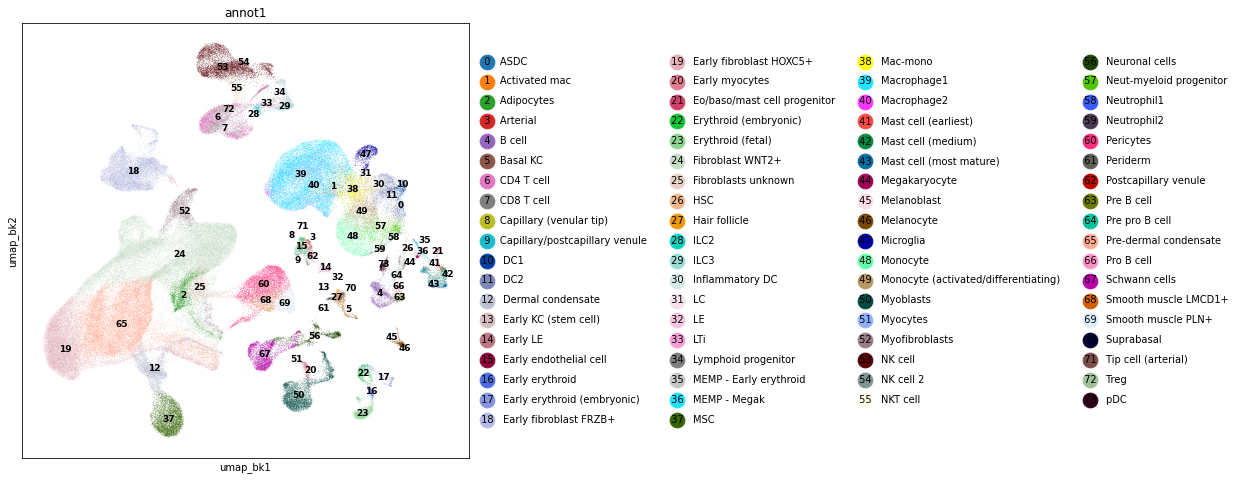

In [31]:
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='annot1', figsize=(8, 8))

In [94]:
kc_ad = ad2[k_kc].copy()

In [49]:
ad2

AnnData object with n_obs × n_vars = 187293 × 28481 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'annot', 'lr_annot', 'leiden_r0_3_annot', 'leiden_r0_1_annot', 'hierarchy1', 'leiden_r1_5_annot', 'celltype', 'annotation', 'annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'pca', 'neighbors_bk', 'neighbors', 'annot1_colors'
    obsm: 'X_pca', 'X_umap_bk', 'X_umap'
    varm: 'PCs'

In [279]:
ss.lib.clear_colors(ad2)
ad2.write('fetal_skin.processed.20200829.h5ad', compression='lzf')

In [23]:
ad2 = sc.read('fetal_skin.processed.20200829.h5ad')

Only considering the two last: ['.20200829', '.h5ad'].
Only considering the two last: ['.20200829', '.h5ad'].


In [ ]:
ad2s = ss.lib.subsample(ad2, fraction=0.05, groupby='annot1', min_n=100, max_n=500)

In [266]:
ad2s

View of AnnData object with n_obs × n_vars = 10722 × 28481 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'hierarchy1', 'celltype', 'annotation', 'annot1', 'annot2', 'Refined', 'Broad_1', 'Broad_2', 'Broad_3', 'Broad_4', 'Broad_5'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'pca', 'neighbors_bk', 'neighbors', 'Broad_3_colors', 'Broad_4_colors', 'Broad_5_colors'
    obsm: 'X_pca', 'X_umap_bk', 'X_umap'
    varm: 'PCs'

In [267]:
ad2s.obsm['X_umap'] = ad0.obsm['X_umap'][ad0.obs_names.isin(ad2s.obs_names), :]

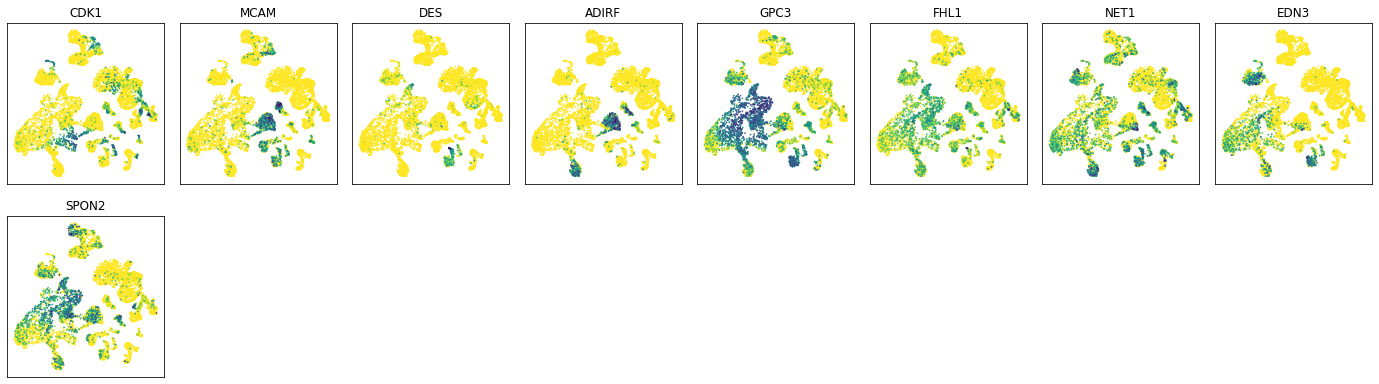

In [205]:
ss.lib.plot_genes(ad2s, basis='umap_bk', figsize=(3,3), genes=['CDK1', 'MCAM', 'DES', 'ADIRF', 'GPC3', 'FHL1', 'NET1', 'EDN3', 'SPON2'], color_map='viridis_r')

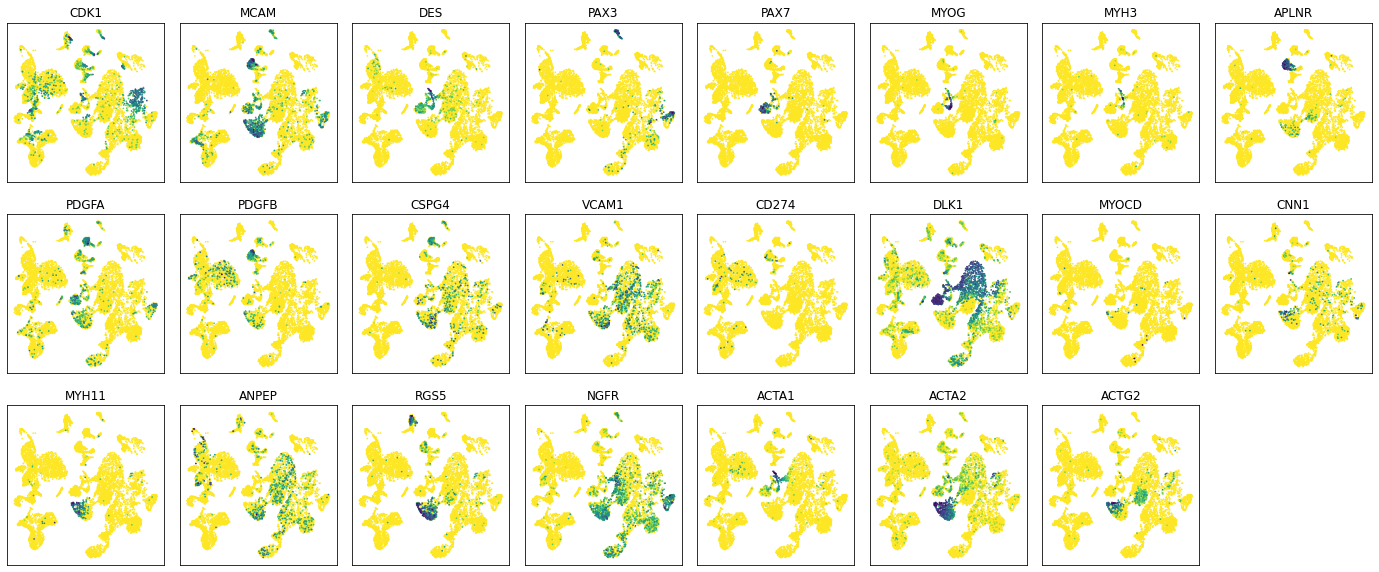

In [178]:
ss.lib.plot_genes(ad2s, basis='umap', genes=[
    'CDK1', 'MCAM', 'DES', 'PAX3', 'PAX7', 'MYOG', 'MYH3',
    'APLNR', 'PDGFA', 'PDGFB', 'CSPG4', 'VCAM1', 'CD274', 'DLK1', 'MYOCD', 'CNN1', 'MYH11',
    'ANPEP', 'RGS5', 'NGFR', 'ACTA1', 'ACTA2', 'ACTG2',
], color_map='viridis_r', figsize=(3,3))

In [79]:
obs_df.head()

scrublet_score  bh_doublet_pval  n_counts  \
index                                                                           
AAACCTGGTCAGTGGA-1-4834STDY7002879        0.225806         0.907861    5917.0   
AAAGATGGTCGATTGT-1-4834STDY7002879        0.149606         0.907861   10261.0   
AAAGCAAAGATGTGGC-1-4834STDY7002879        0.201970         0.882352    7749.0   
AAAGTAGCAGATCGGA-1-4834STDY7002879        0.164557         0.907861   14791.0   
AAAGTAGTCCGCATCT-1-4834STDY7002879        0.181818         0.882352    7434.0   

                                    n_genes  percent_mito  percent_ribo  \
index                                                                     
AAACCTGGTCAGTGGA-1-4834STDY7002879     1776      6.253169     26.229507   
AAAGATGGTCGATTGT-1-4834STDY7002879     2750      3.089368     24.880617   
AAAGCAAAGATGTGGC-1-4834STDY7002879     2308      1.264679     22.583559   
AAAGTAGCAGATCGGA-1-4834STDY7002879     3099      1.744304     34.581841   
AAAGTAGTCCGCATCT-1-4834STDY7002879     2283      4.143126     22.114609   

                                    percent_hb  \
index                                            
AAACCTGGTCAGTGGA-1-4834STDY7002879    0.135204   
AAAGATGGTCGATTGT-1-4834STDY7002879    0.155930   
AAAGCAAAGATGTGGC-1-4834STDY7002879    0.129049   
AAAGTAGCAGATCGGA-1-4834STDY7002879    0.108174   
AAAGTAGTCCGCATCT-1-4834STDY7002879    0.080710   

                                                              annotation  \
index                                                                      
AAACCTGGTCAGTGGA-1-4834STDY7002879                           Macrophage1   
AAAGATGGTCGATTGT-1-4834STDY7002879  Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879                           Macrophage1   
AAAGTAGCAGATCGGA-1-4834STDY7002879          Eo/baso/mast cell progenitor   
AAAGTAGTCCGCATCT-1-4834STDY7002879                           Macrophage1   

                                   L1_celltypes  \
index                                             
AAACCTGGTCAGTGGA-1-4834STDY7002879      myeloid   
AAAGATGGTCGATTGT-1-4834STDY7002879      myeloid   
AAAGCAAAGATGTGGC-1-4834STDY7002879      myeloid   
AAAGTAGCAGATCGGA-1-4834STDY7002879   mast_cells   
AAAGTAGTCCGCATCT-1-4834STDY7002879      myeloid   

                                                                   annot  \
index                                                                      
AAACCTGGTCAGTGGA-1-4834STDY7002879                           Macrophage1   
AAAGATGGTCGATTGT-1-4834STDY7002879  Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879                           Macrophage1   
AAAGTAGCAGATCGGA-1-4834STDY7002879          Eo/baso/mast cell progenitor   
AAAGTAGTCCGCATCT-1-4834STDY7002879                           Macrophage1   

                                   chemistry donor gender  pcw  \
index                                                            
AAACCTGGTCAGTGGA-1-4834STDY7002879    SC3Pv2   F16   male    8   
AAAGATGGTCGATTGT-1-4834STDY7002879    SC3Pv2   F16   male    8   
AAAGCAAAGATGTGGC-1-4834STDY7002879    SC3Pv2   F16   male    8   
AAAGTAGCAGATCGGA-1-4834STDY7002879    SC3Pv2   F16   male    8   
AAAGTAGTCCGCATCT-1-4834STDY7002879    SC3Pv2   F16   male    8   

                                             sample        sanger_id sorting  \
index                                                                          
AAACCTGGTCAGTGGA-1-4834STDY7002879  F16_male_8+1PCW  4834STDY7002879   CD45P   
AAAGATGGTCGATTGT-1-4834STDY7002879  F16_male_8+1PCW  4834STDY7002879   CD45P   
AAAGCAAAGATGTGGC-1-4834STDY7002879  F16_male_8+1PCW  4834STDY7002879   CD45P   
AAAGTAGCAGATCGGA-1-4834STDY7002879  F16_male_8+1PCW  4834STDY7002879   CD45P   
AAAGTAGTCCGCATCT-1-4834STDY7002879  F16_male_8+1PCW  4834STDY7002879   CD45P   

                                           sample_sorting  \
index                                                       
AAACCTGGTCAGTGGA-1-48

In [101]:
obs_df['annot2'].sort_values().unique()

array(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal', 'Basal POSTN+', 'Basal SHH+', 'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'Companion layer', 'Cuticle/cortex', 'DC1', 'DC2', 'Dermal condensate', 'Early LE', 'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'Early fibroblast FRZB+', 'Early fibroblast HOXC5+', 'Early myocytes', 'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast WNT2+', 'Fibroblasts unknown', 'HSC', 'ILC2', 'ILC3', 'Immature basal', 'Immature suprabasal', 'Inflammatory DC', 'Inner root sheath',
       'LC', 'LE', 'LTi', 'Lymphoid progenitor', 'MEMP - Early erythroid', 'MEMP - Megak', 'MSC', 'Mac-mono', 'Macrophage1', 'Macrophage2', 'Mast cell (earliest)',
       'Mast cell (medium)', 'Mast cell (most mature)', 'Megakaryocyte', 'Melanoblast', 'Melanocyte', 'Microglia', 'Monocyte', 'Monocyte (activated/differentiating

In [108]:
obs_df[['annot1', 'annot2']].to_csv('fetal_skin.annotation.20200829.tsv', sep='\t', index=True, header=True)

In [109]:
pd.DataFrame({'Refined': obs_df.annot1.sort_values().unique()}).to_csv('fetal_skin.independent_annot_celltypes.20200829.tsv', sep='\t', index=False, header=True)

In [252]:
celltype_df = pd.read_csv('fetal_skin.independent_annot_celltypes.20200829.tsv', sep='\t')

In [253]:
celltype_df.head()

Refined               Broad_1               Broad_2  \
0           ASDC                  ASDC                   cDC   
1  Activated mac            Macrophage            Macrophage   
2     Adipocytes             Adipocyte             Adipocyte   
3       Arterial  Vascular endothelium  Vascular endothelium   
4         B cell                B cell                B cell   

                Broad_3                   Broad_4 Broad_5  
0                    DC  Antigen Presenting Cells  Immune  
1            Macrophage  Antigen Presenting Cells  Immune  
2             Adipocyte         Mesenchymal cells  Stroma  
3  Vascular endothelium               Endothelium  Stroma  
4                B cell               Lymphocytes  Immune

In [254]:
ad2.obs.merge(celltype_df, left_on='annot1', right_on='Refined').head()

bh_doublet_pval cell_caller  cluster_scrublet_score  doublet_pval  \
0         0.907861        Both                0.157082      0.500000   
1         0.882352        Both                0.225806      0.150885   
2         0.882352        Both                0.201970      0.250000   
3         0.882352        Both                0.213888      0.196672   
4         0.882352        Both                0.201970      0.250000   

    mt_prop  n_counts  n_genes        sanger_id  scrublet_score chemistry  \
0  0.062532    5917.0     1776  4834STDY7002879        0.225806    SC3Pv2   
1  0.012647    7749.0     2308  4834STDY7002879        0.201970    SC3Pv2   
2  0.041431    7434.0     2283  4834STDY7002879        0.181818    SC3Pv2   
3  0.034322    5157.0     1899  4834STDY7002879        0.254438    SC3Pv2   
4  0.037595   11943.0     2880  4834STDY7002879        0.289474    SC3Pv2   

   ...   Broad_2_x   Broad_3_x                  Broard_4 Broad_5_x  \
0  ...  Macrophage  Macrophage  Antigen Presenting Cells    Immune   
1  ...  Macrophage  Macrophage  Antigen Presenting Cells    Immune   
2  ...  Macrophage  Macrophage  Antigen Presenting Cells    Immune   
3  ...  Macrophage  Macrophage  Antigen Presenting Cells    Immune   
4  ...  Macrophage  Macrophage  Antigen Presenting Cells    Immune   

     Refined_y   Broad_1_y   Broad_2_y   Broad_3_y                   Broad_4  \
0  Macrophage1  Macrophage  Macrophage  Macrophage  Antigen Presenting Cells   
1  Macrophage1  Macrophage  Macrophage  Macrophage  Antigen Presenting Cells   
2  Macrophage1  Macrophage  Macrophage  Macrophage  Antigen Presenting Cells   
3  Macrophage1  Macrophage  Macrophage  Macrophage  Antigen Presenting Cells   
4  Macrophage1  Macrophage  Macrophage  Macrophage  Antigen Presenting Cells   

  Broad_5_y  
0    Immune  
1    Immune  
2    Immune  
3    Immune  
4    Immune  

[5 rows x 42 columns]

In [255]:
ad2

AnnData object with n_obs × n_vars = 187293 × 28481 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'hierarchy1', 'celltype', 'annotation', 'annot1', 'annot2', 'Refined', 'Broad_1', 'Broad_2', 'Broad_3', 'Broard_4', 'Broad_5'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'pca', 'neighbors_bk', 'neighbors', 'Broad_3_colors'
    obsm: 'X_pca', 'X_umap_bk', 'X_umap'
    varm: 'PCs'

In [256]:
obs_df2 = ad2.obs[[
    'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score',
    'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id',
    'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting',
    'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo',
    'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5',
    'leiden_r0_7', 'leiden_r1_5', 'doublet', 'hierarchy1',
    'celltype', 'annotation', 'annot1', 'annot2'
]].reset_index().reset_index().merge(celltype_df, left_on='annot1', right_on='Refined').sort_values('level_0').set_index('index').drop(columns=['level_0'])

In [257]:
obs_df2.columns

Index(['bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score',
       'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id',
       'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting',
       'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo',
       'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5',
       'leiden_r0_7', 'leiden_r1_5', 'doublet', 'hierarchy1', 'celltype',
       'annotation', 'annot1', 'annot2', 'Refined', 'Broad_1', 'Broad_2',
       'Broad_3', 'Broad_4', 'Broad_5'],
      dtype='object')

In [258]:
ad2.obs = obs_df2

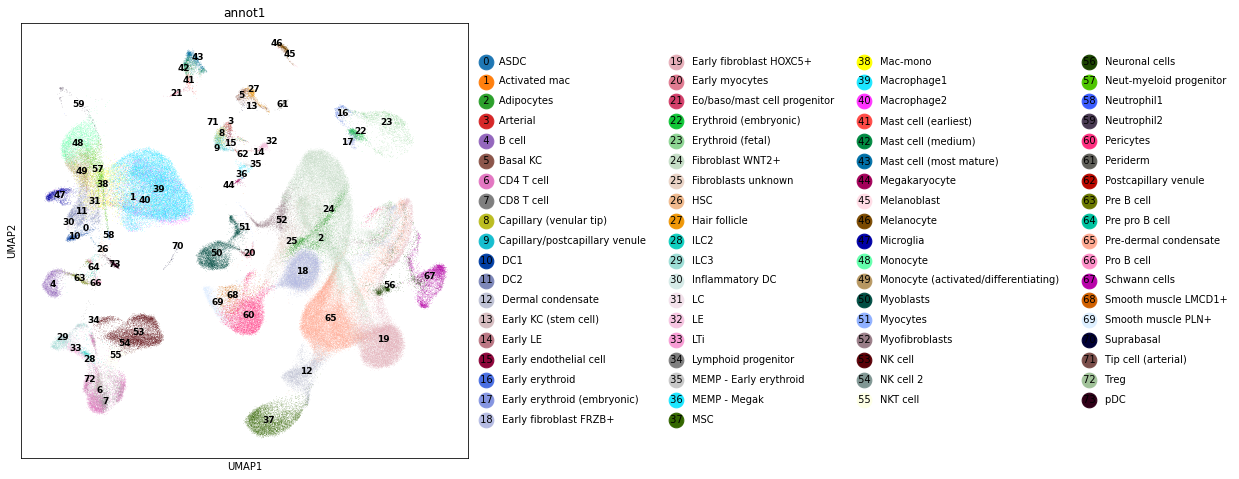

In [90]:
ss.lib.plot_embedding(ad0, basis='umap', groupby='annot1', figsize=(8, 8))

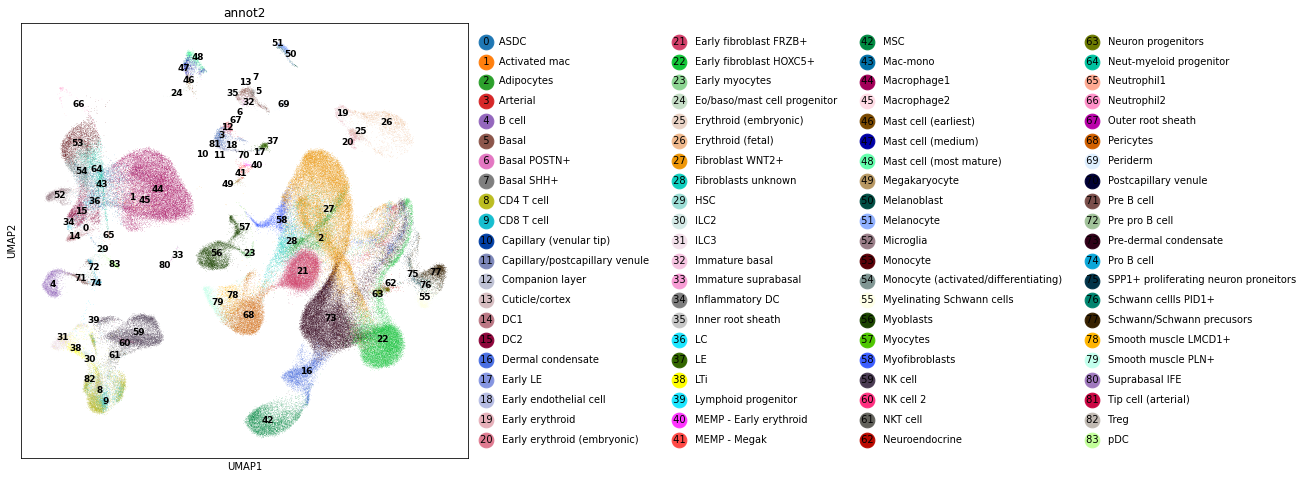

In [91]:
ss.lib.plot_embedding(ad0, basis='umap', groupby='annot2', figsize=(8, 8))

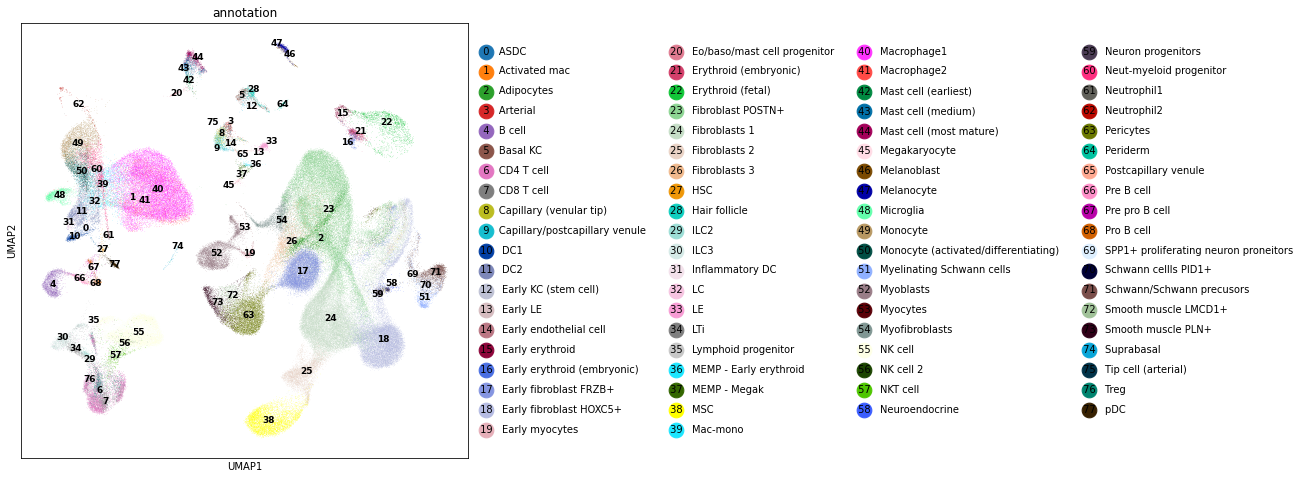

In [158]:
ss.lib.plot_embedding(ad2, basis='umap', groupby='annotation', figsize=(8, 8));

... storing 'annot1' as categorical
... storing 'Refined' as categorical
... storing 'Broad_2' as categorical
... storing 'Broad_3' as categorical


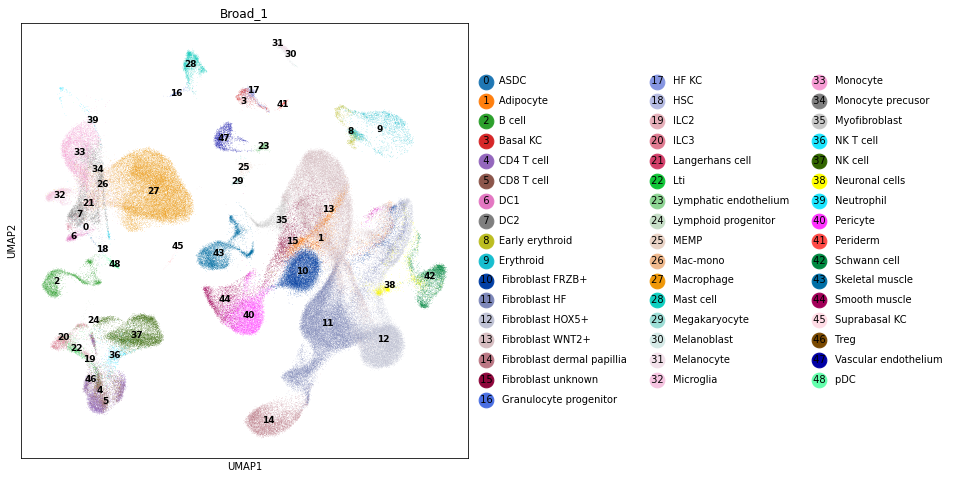

In [186]:
ss.lib.plot_embedding(ad2, basis='umap', groupby='Broad_1', figsize=(8, 8));

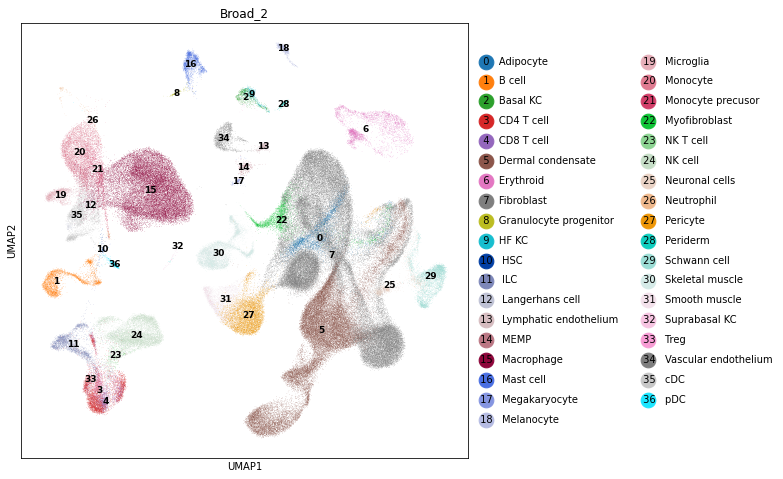

In [187]:
ss.lib.plot_embedding(ad2, basis='umap', groupby='Broad_2', figsize=(8, 8));

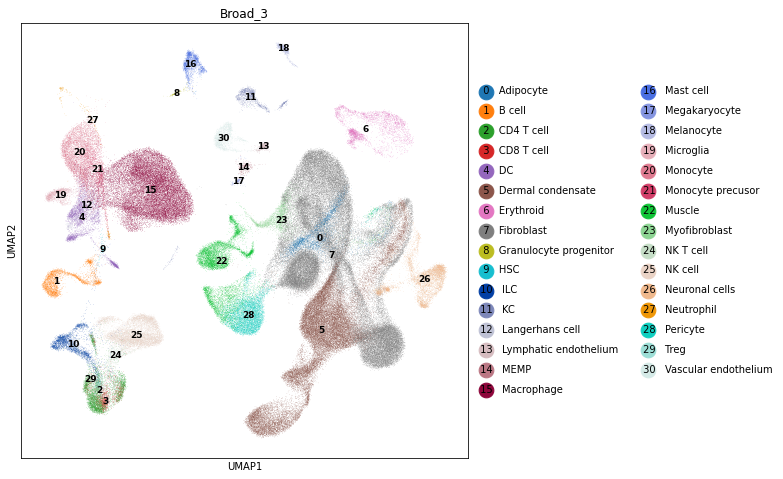

In [5]:
ss.lib.plot_embedding(ad2, basis='umap', groupby='Broad_3', figsize=(8, 8));

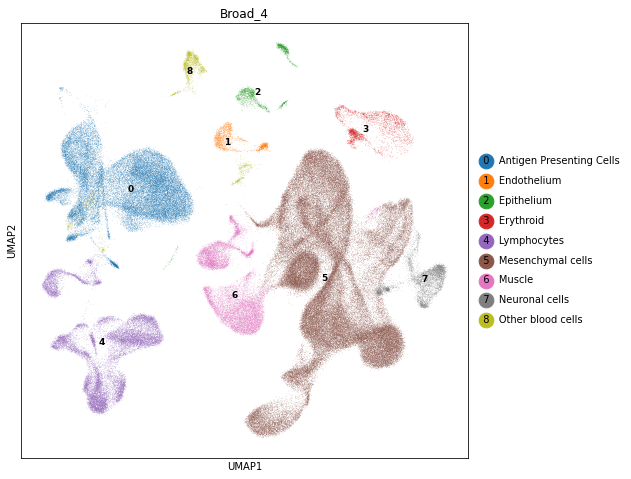

In [263]:
ss.lib.plot_embedding(ad2, basis='umap', groupby='Broad_4', figsize=(8, 8));

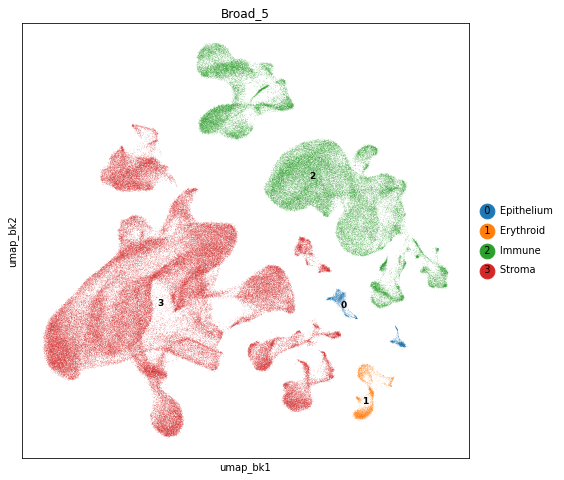

In [261]:
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='Broad_5', figsize=(8, 8));

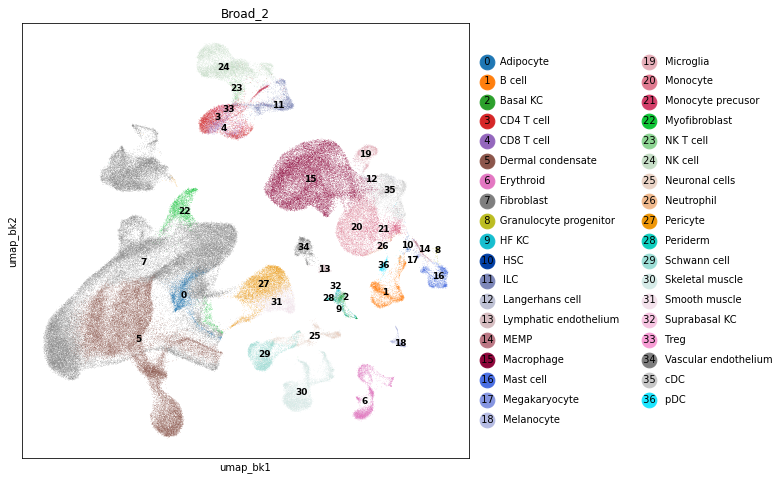

In [191]:
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='Broad_2', figsize=(8, 8));

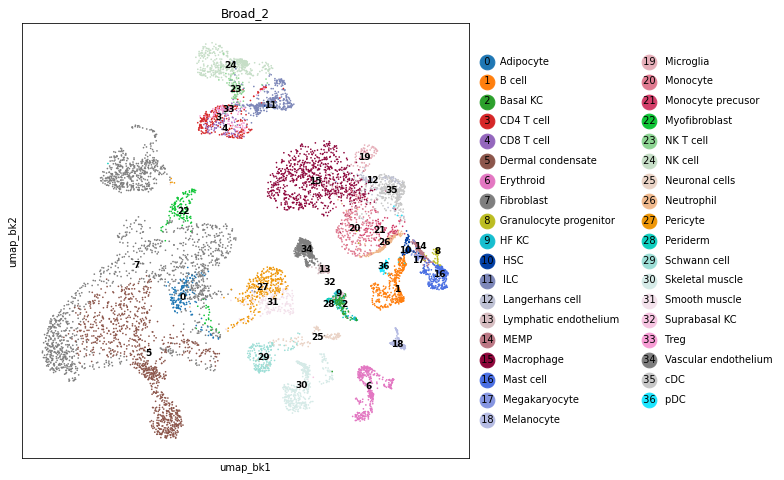

In [209]:
ss.lib.plot_embedding(ad2s, basis='umap_bk', groupby='Broad_2', figsize=(8, 8));

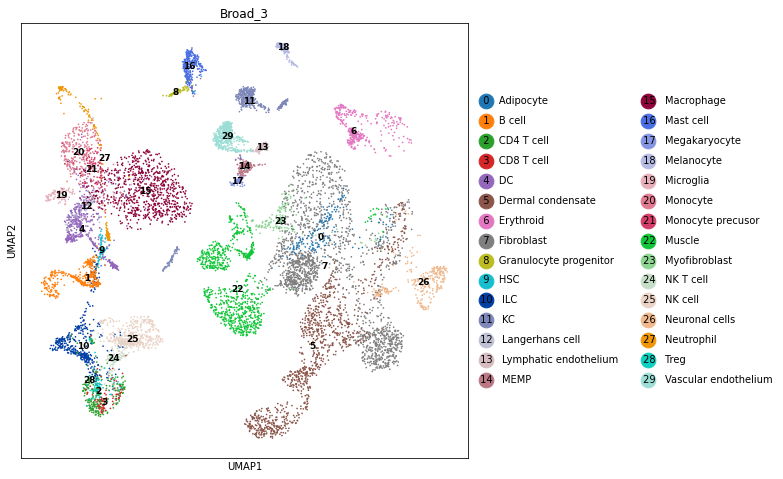

In [212]:
ss.lib.plot_embedding(ad2s, basis='umap', groupby='Broad_3', figsize=(8, 8));

In [221]:
plot_df = pd.concat([
    ad2.obs,
    pd.DataFrame(ad2.obsm['X_umap'], index=ad2.obs_names, columns=['UMAP1a', 'UMAP2a']),
    pd.DataFrame(ad2.obsm['X_umap_bk'], index=ad2.obs_names, columns=['UMAP1b', 'UMAP2b'])
], axis=1)

In [223]:
plot_df.head()

bh_doublet_pval cell_caller  \
index                                                             
AAACCTGGTCAGTGGA-1-4834STDY7002879         0.907861        Both   
AAAGATGGTCGATTGT-1-4834STDY7002879         0.907861        Both   
AAAGCAAAGATGTGGC-1-4834STDY7002879         0.882352        Both   
AAAGTAGCAGATCGGA-1-4834STDY7002879         0.907861        Both   
AAAGTAGTCCGCATCT-1-4834STDY7002879         0.882352        Both   

                                    cluster_scrublet_score  doublet_pval  \
index                                                                      
AAACCTGGTCAGTGGA-1-4834STDY7002879                0.157082      0.500000   
AAAGATGGTCGATTGT-1-4834STDY7002879                0.157082      0.500000   
AAAGCAAAGATGTGGC-1-4834STDY7002879                0.225806      0.150885   
AAAGTAGCAGATCGGA-1-4834STDY7002879                0.164557      0.455284   
AAAGTAGTCCGCATCT-1-4834STDY7002879                0.201970      0.250000   

                                     mt_prop  n_counts  n_genes  \
index                                                             
AAACCTGGTCAGTGGA-1-4834STDY7002879  0.062532    5917.0     1776   
AAAGATGGTCGATTGT-1-4834STDY7002879  0.030894   10261.0     2750   
AAAGCAAAGATGTGGC-1-4834STDY7002879  0.012647    7749.0     2308   
AAAGTAGCAGATCGGA-1-4834STDY7002879  0.017443   14791.0     3099   
AAAGTAGTCCGCATCT-1-4834STDY7002879  0.041431    7434.0     2283   

                                          sanger_id  scrublet_score chemistry  \
index                                                                           
AAACCTGGTCAGTGGA-1-4834STDY7002879  4834STDY7002879        0.225806    SC3Pv2   
AAAGATGGTCGATTGT-1-4834STDY7002879  4834STDY7002879        0.149606    SC3Pv2   
AAAGCAAAGATGTGGC-1-4834STDY7002879  4834STDY7002879        0.201970    SC3Pv2   
AAAGTAGCAGATCGGA-1-4834STDY7002879  4834STDY7002879        0.164557    SC3Pv2   
AAAGTAGTCCGCATCT-1-4834STDY7002879  4834STDY7002879        0.181818    SC3Pv2   

                                    ...                                annot1  \
index                               ...                                         
AAACCTGGTCAGTGGA-1-4834STDY7002879  ...                           Macrophage1   
AAAGATGGTCGATTGT-1-4834STDY7002879  ...  Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879  ...                           Macrophage1   
AAAGTAGCAGATCGGA-1-4834STDY7002879  ...          Eo/baso/mast cell progenitor   
AAAGTAGTCCGCATCT-1-4834STDY7002879  ...                           Macrophage1   

                                                                  annot2  \
index                                                                      
AAACCTGGTCAGTGGA-1-4834STDY7002879                           Macrophage1   
AAAGATGGTCGATTGT-1-4834STDY7002879  Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879                           Macrophage1   
AAAGTAGCAGATCGGA-1-4834STDY7002879          Eo/baso/mast cell progenitor   
AAAGTAGTCCGCATCT-1-4834STDY7002879                           Macrophage1   

                                                                 Refined  \
index                                                                      
AAACCTGGTCAGTGGA-1-4834STDY7002879                           Macrophage1   
AAAGATGGTCGATTGT-1-4834STDY7002879  Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879                           Macrophage1   
AAAGTAGCAGATCGGA-1-4834STDY7002879          Eo/baso/mast cell progenitor   
AAAGTAGTCCGCATCT-1-4834STDY7002879                           Macrophage1   

                                                   Broad_1  \
index                                                        
AAACCTGGTCAGTGGA-1-4834STDY7002879              Macrophage   
AAAGATGGTCGATTGT-1-4834STDY7002879                Monocyte   
AAAGCAAAGATGTGGC-1-4834STDY7002879              Macrophage   
AAAGTAGCAGATCGGA-1-4834STDY7002879  Granulocyte pro

In [224]:
plot_df.to_csv('fetal_skin.annotation_with_UMAP.20200829.tsv', sep='\t')

In [225]:
ad2s

AnnData object with n_obs × n_vars = 10722 × 28481 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r1_5', 'doublet', 'annot', 'lr_annot', 'leiden_r0_3_annot', 'leiden_r0_1_annot', 'hierarchy1', 'leiden_r1_5_annot', 'celltype', 'annotation', 'annot1', 'annot2', 'Refined', 'Broad_1', 'Broad_2', 'Broad_3'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'pca', 'neighbors_bk', 'neighbors', 'Broad_2_colors', 'Broad_3_colors'
    obsm: 'X_pca', 'X_umap_bk', 'X_umap'
    varm: 'PCs'

In [226]:
ss.lib.diffexp(ad2s, groupby='Broad_2', key_added='broad2', filter_params=[0.3, 0.2, 2]);

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [237]:
ss.lib.diffexp(ad2s, method='logreg', groupby='Broad_2', key_added='broad2lr', filter_params=[0.3, 0.2, 2]);

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [4]:
sc.pl.rank_genes_groups_dotplot(ad2s, groupby='Broad_2', n_genes=1, key='rank_genes_groups_broad2', save='fetal_skin.marker_by_broad2.png')

NameError: name 'ad2s' is not defined

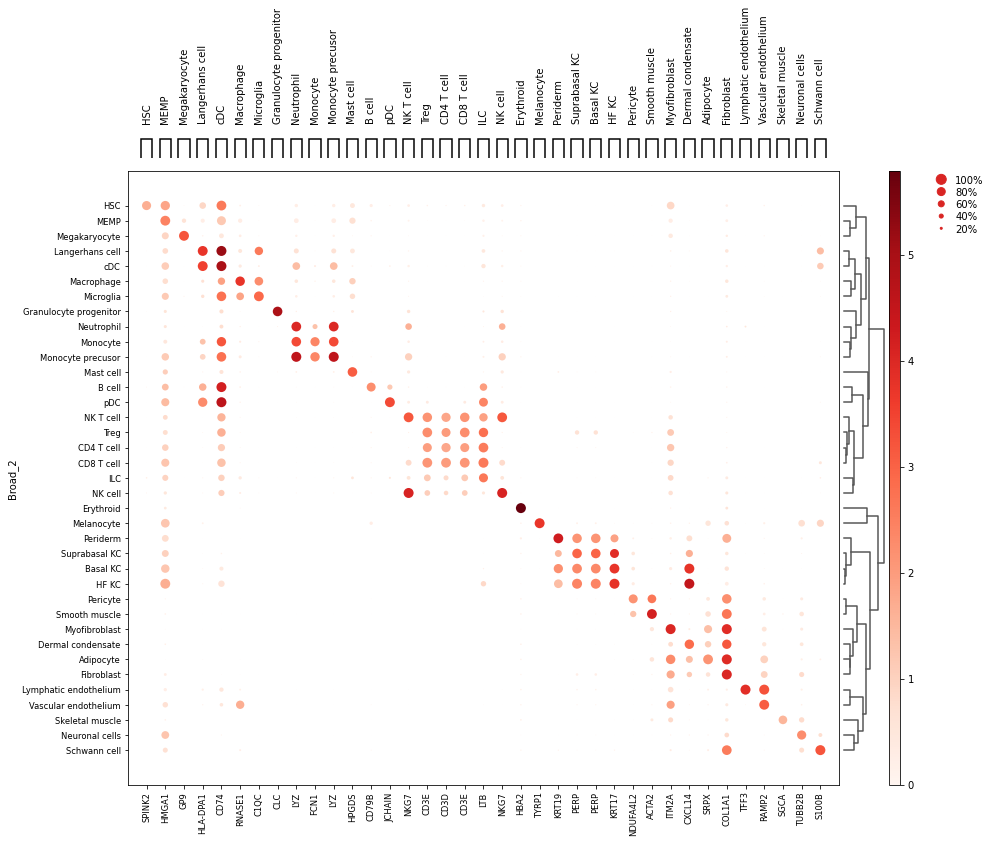

In [235]:
sc.pl.rank_genes_groups_dotplot(ad2s, groupby='Broad_2', n_genes=1, key='rank_genes_groups_broad2')

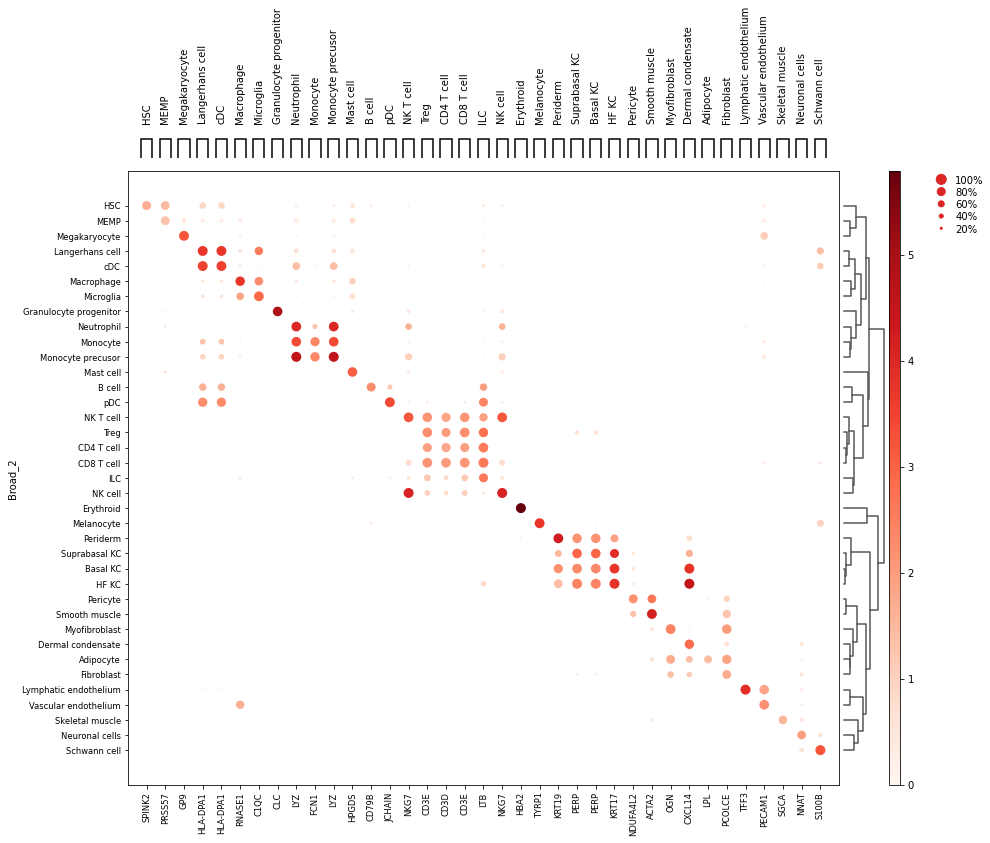

In [234]:
sc.pl.rank_genes_groups_dotplot(ad2s, groupby='Broad_2', n_genes=1, key='rank_genes_groups_broad2_filtered')

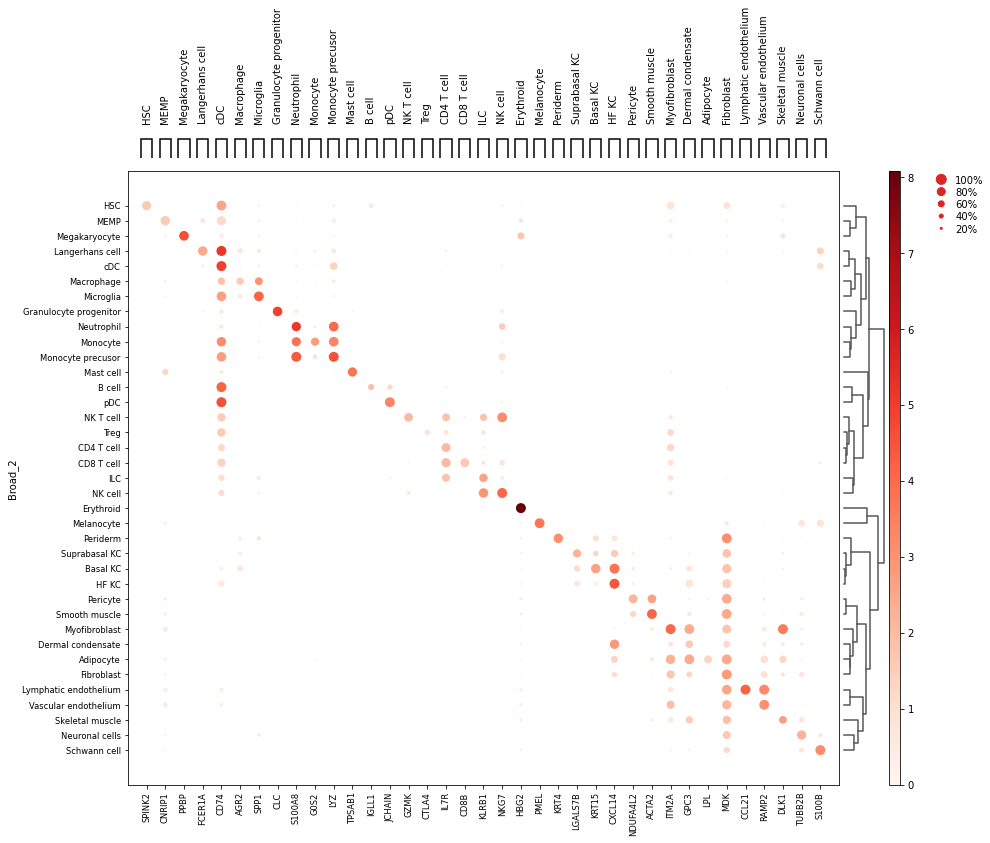

In [238]:
sc.pl.rank_genes_groups_dotplot(ad2s, groupby='Broad_2', n_genes=1, key='rank_genes_groups_broad2lr')

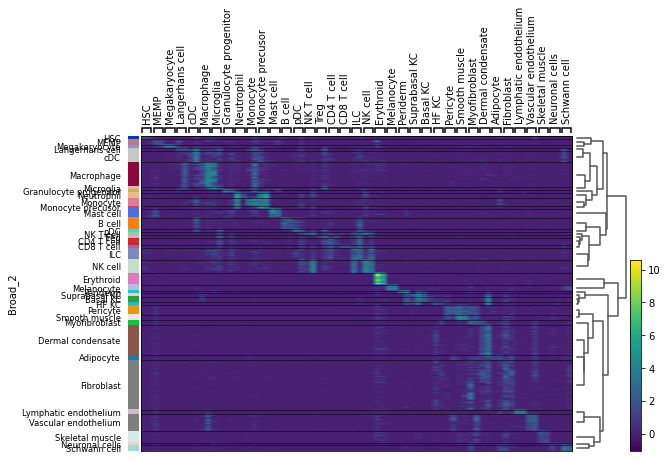

In [244]:
sc.pl.rank_genes_groups_heatmap(ad2s, groupby='Broad_2', n_genes=2, key='rank_genes_groups_broad2lr_filtered')

In [268]:
ad2s.write('fetal_skin.processed.downsampled.20200829.h5ad', compression='lzf')

In [2]:
ad2s = sc.read('fetal_skin.processed.downsampled.20200829.h5ad')

Only considering the two last: ['.20200829', '.h5ad'].
Only considering the two last: ['.20200829', '.h5ad'].


In [18]:
ad2s.obs.annotation.cat.categories

Index(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal KC',
       'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'DC1', 'DC2', 'Early KC (stem cell)',
       'Early LE', 'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'Early fibroblast FRZB+',
       'Early fibroblast HOXC5+', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast POSTN+', 'Fibroblasts 1',
       'Fibroblasts 2', 'Fibroblasts 3', 'HSC', 'Hair follicle', 'ILC2',
       'ILC3', 'Inflammatory DC', 'LC', 'LE', 'LTi', 'Lymphoid progenitor',
       'MEMP - Early erythroid', 'MEMP - Megak', 'MSC', 'Mac-mono',
       'Macrophage1', 'Macrophage2', 'Mast cell (earliest)',
       'Mast cell (medium)', 'Mast cell (most mature)', 'Megakaryocyte',
       'Melanoblast', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte (activated/differentiating)', 'Myelinati

In [24]:
nr_ad2 = ad2[ad2.obs.annotation.isin([
    'Myelinating Schwann cells', 'Neuroendocrine', 'Neuron progenitors',
    'SPP1+ proliferating neuron proneitors', 'Schwann cellls PID1+', 'Schwann/Schwann precusors'
])].copy()

In [25]:
mkst_nr = sk.calc_marker_stats(nr_ad2, groupby='annotation')

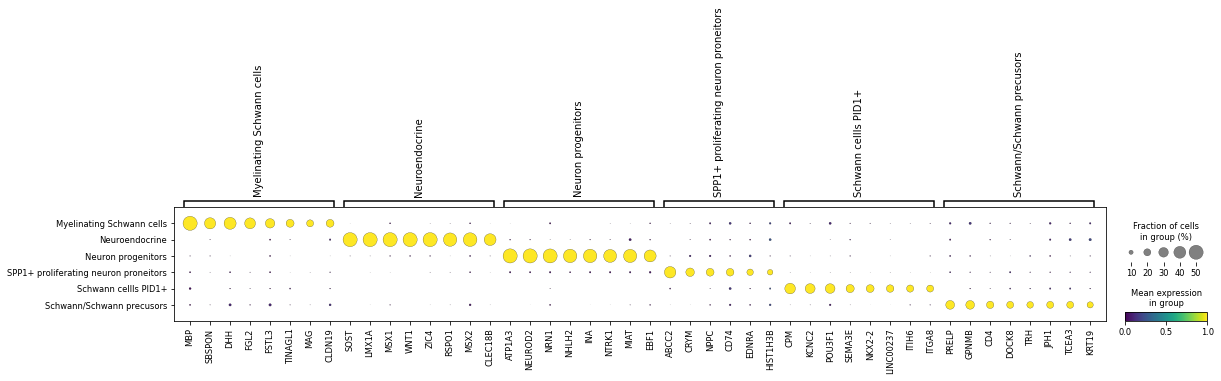

In [36]:
mks_nr = sk.filter_marker_stats(mkst_nr[2], max_next_frac=0.05)
sk.plot_markers(nr_ad2, groupby='annotation', mks=mks_nr, n_genes=8, standard_scale='var', cmap='viridis', dot_max=0.5)#, swap_axes=True)

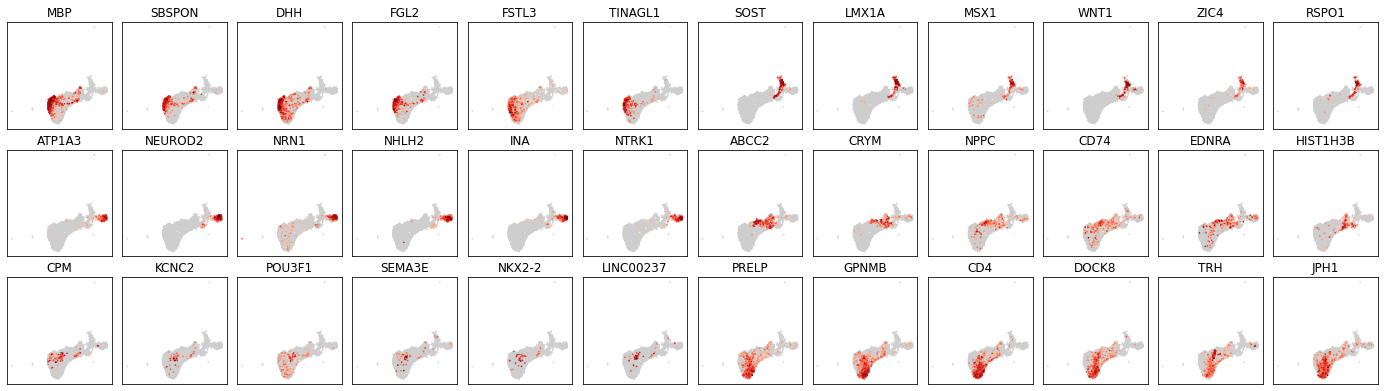

In [32]:
sk.plot_genes(nr_ad2, basis='umap_bk', genes=mks_nr.groupby('top_frac_group').head(6).index.to_list(), size=10)

In [3]:
mkst = sk.calc_marker_stats(ad2s, groupby='Broad_2')

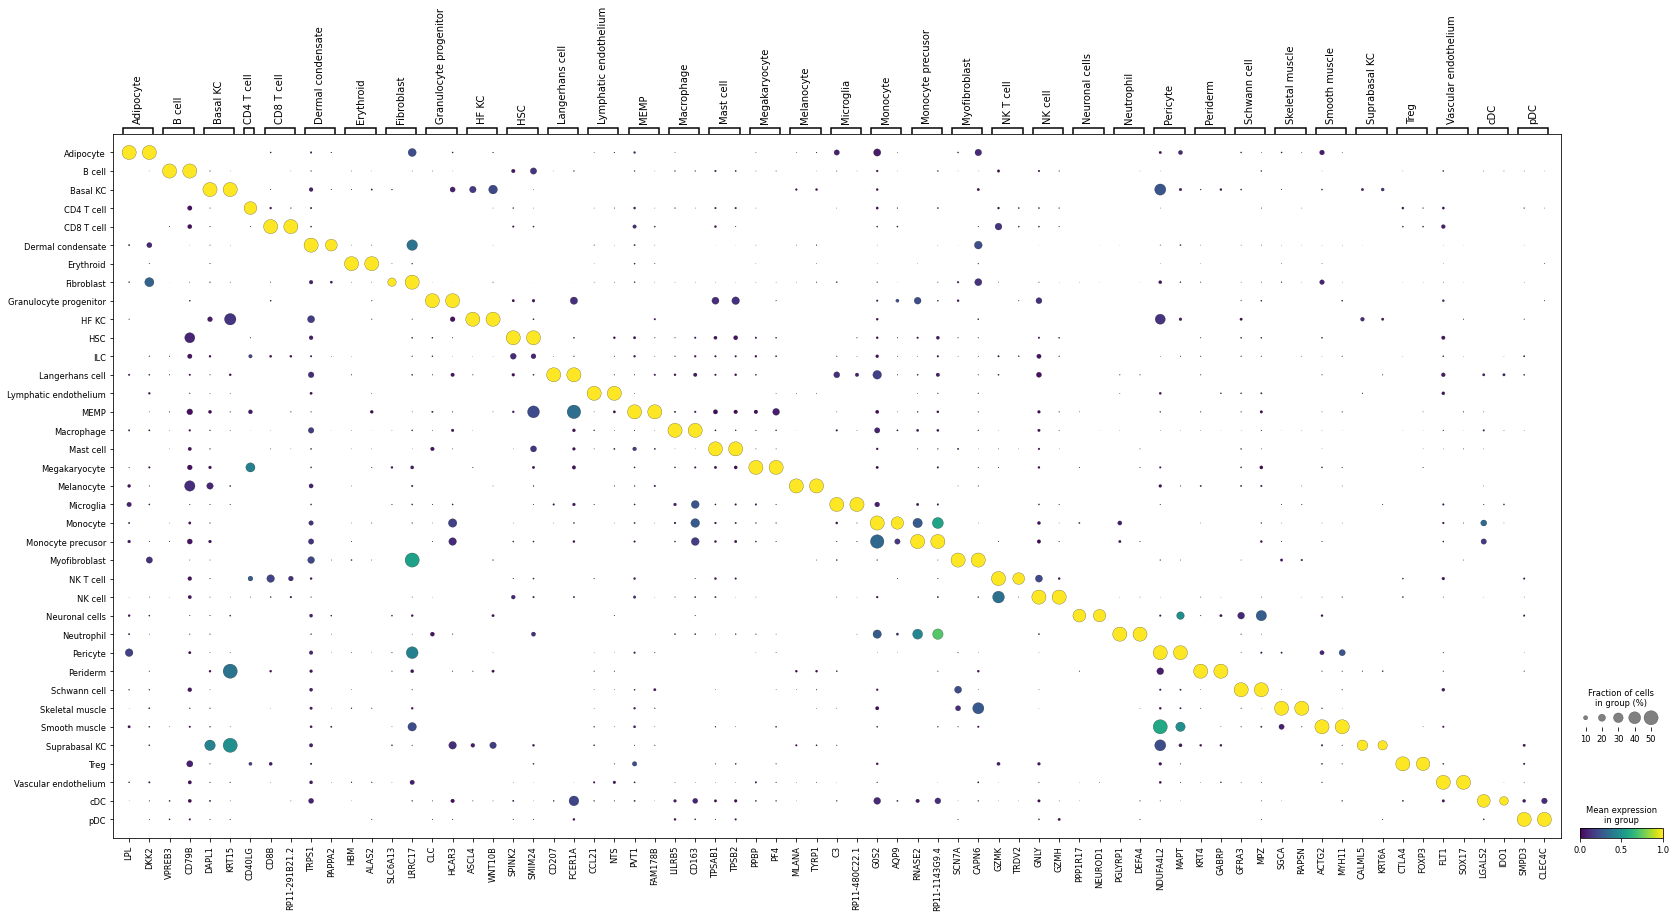

In [14]:
mks = sk.filter_marker_stats(mkst[2], max_next_frac=0.8, min_mean_diff=0.3)
sk.plot_markers(ad2s, groupby='Broad_2', mks=mks, n_genes=2, standard_scale='var', cmap='viridis', dot_max=0.5)

In [4]:
mkst = sk.calc_marker_stats(ad2s, groupby='annotation')

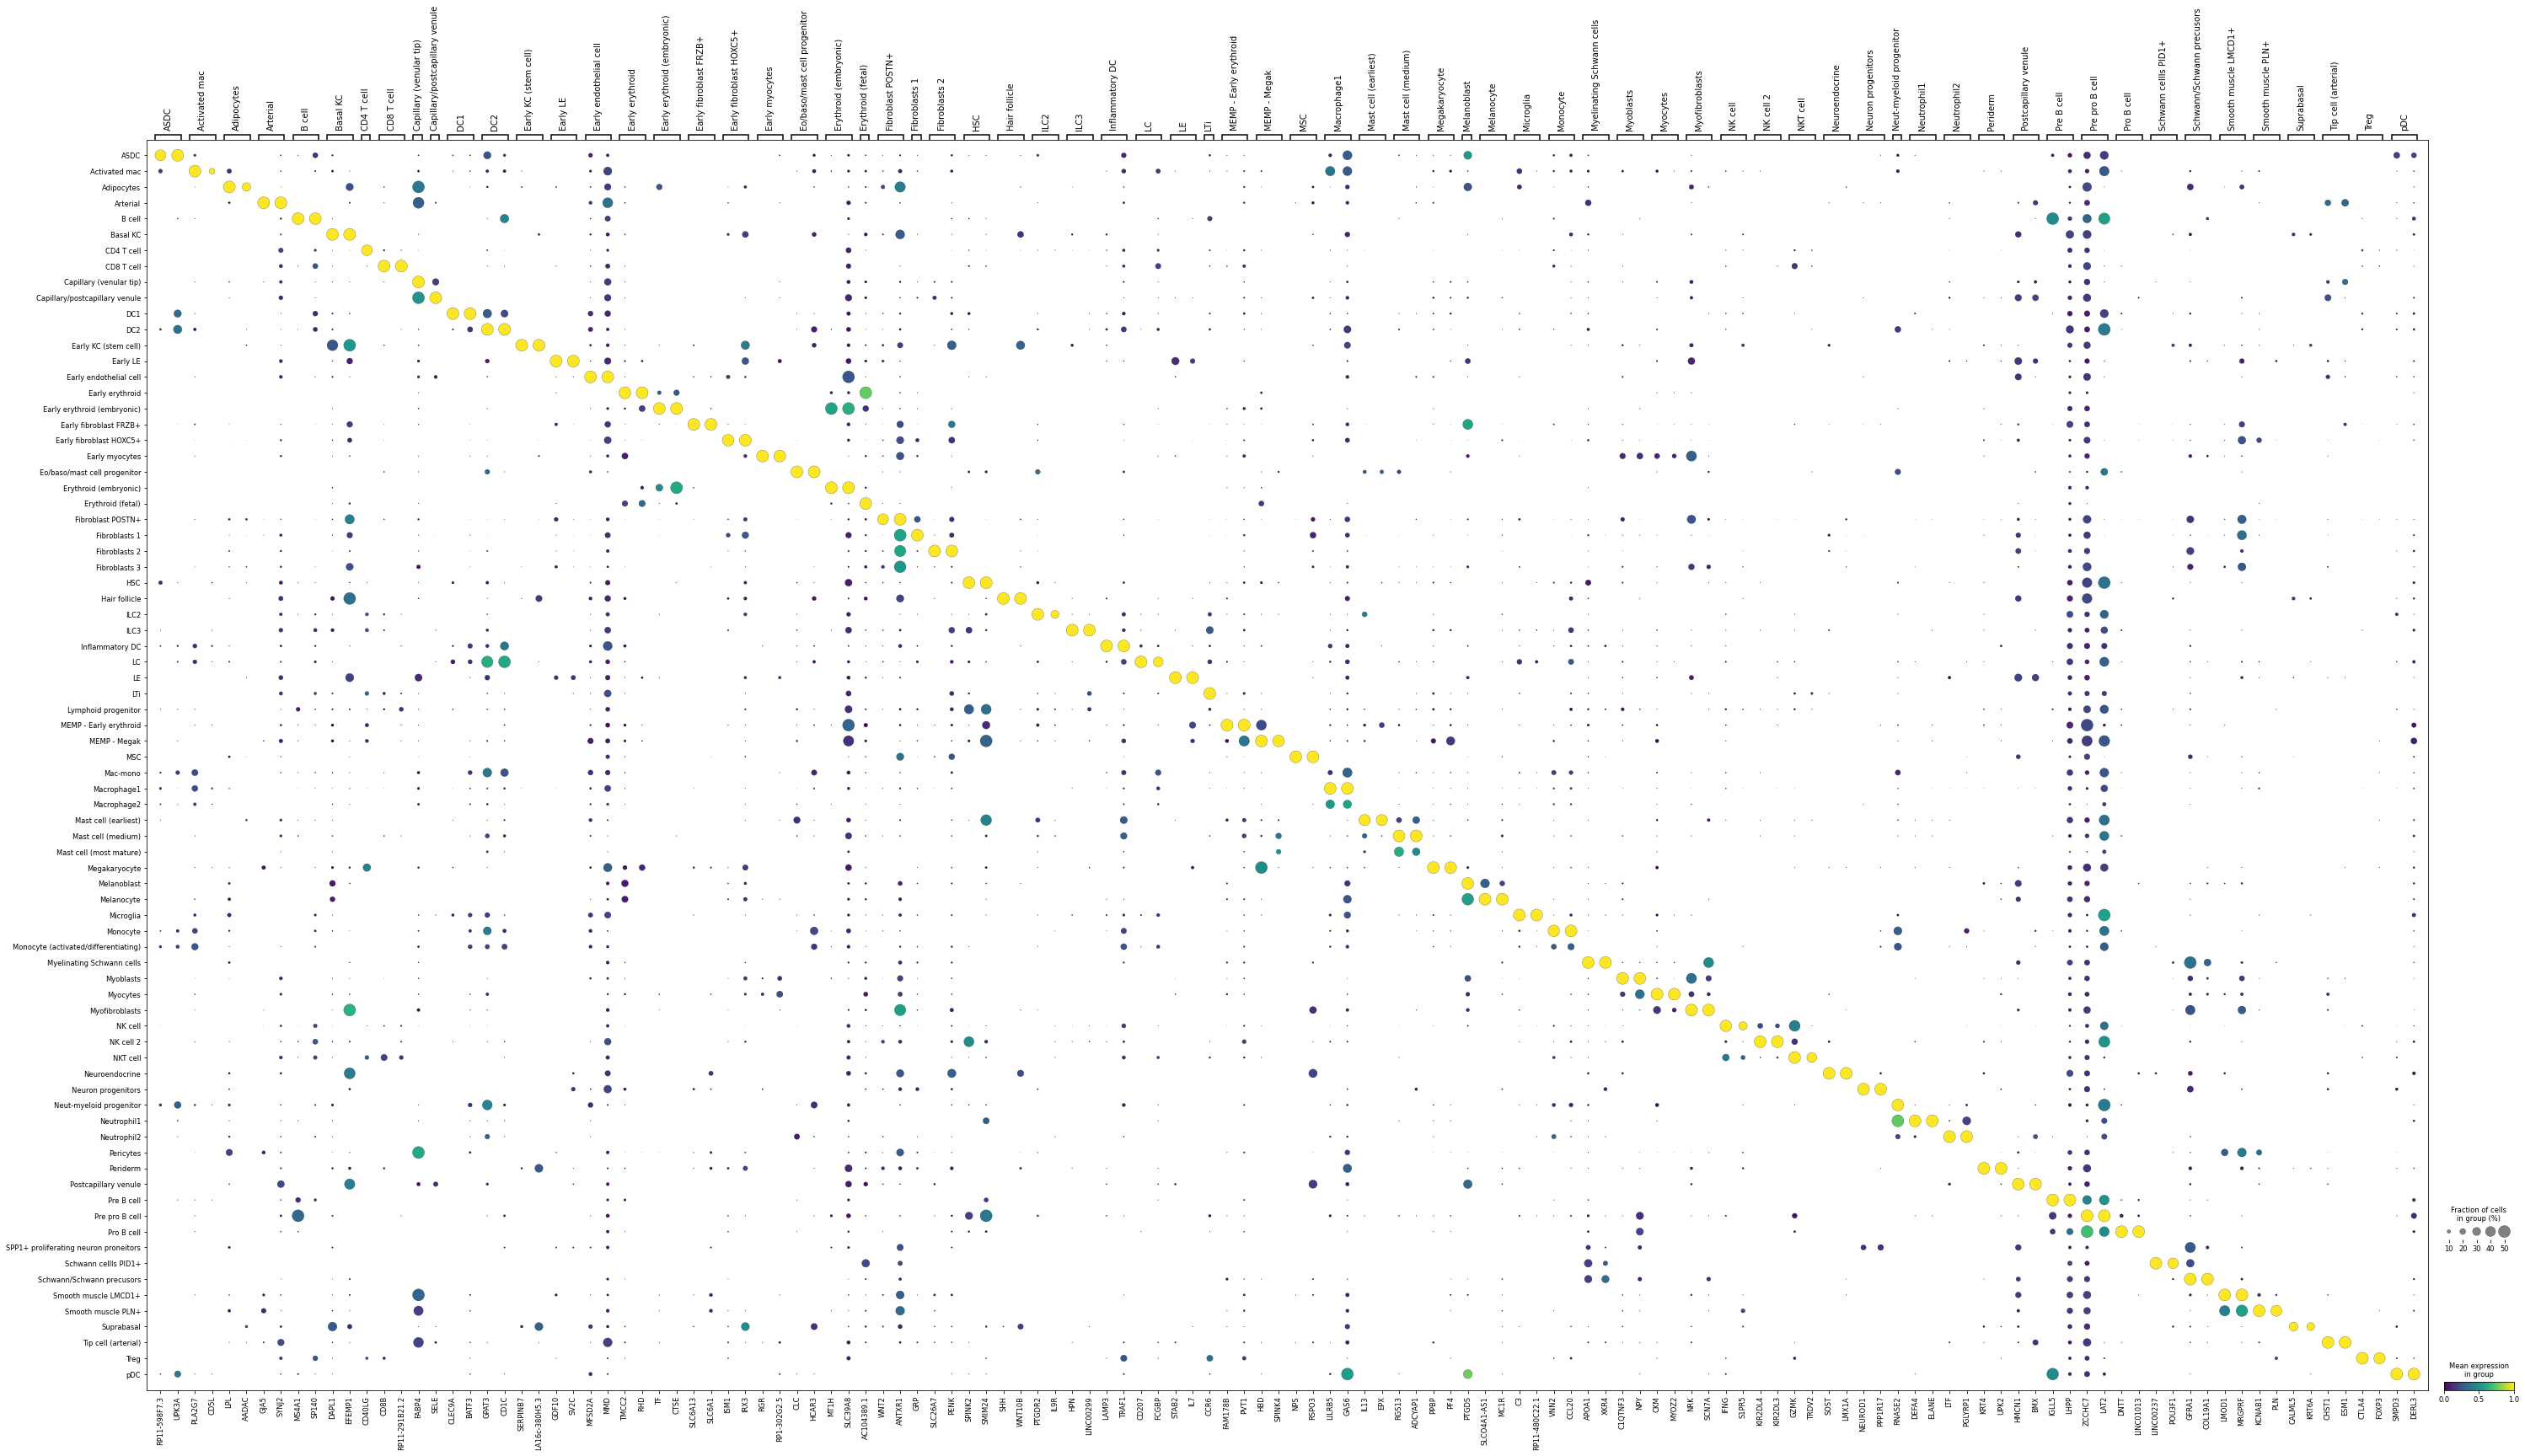

In [5]:
mks = sk.filter_marker_stats(mkst[2], max_next_frac=0.8, min_mean_diff=0.3)
sk.plot_markers(ad2s, groupby='annotation', mks=mks, n_genes=2, standard_scale='var', cmap='viridis', dot_max=0.5)